## Imports library

In [1]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#import external libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import time
%matplotlib inline

Check for CUDA

In [4]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)

True
True
cuda


## Read inputs

### Separate into labels and training images and reshape the images

In [5]:

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [24]:
dataset_path = "D:\\learning\\EE Courses\\Neural Network (D. Kalhor)\\HW\\HW Extra\\handwritten-Persian-numbers-recognition\\Data\\Hoda Dataset\\"
# size of images
image_height = 40
image_width = 40

In [31]:
# load train images
train_images, train_labels = read_hoda_dataset(dataset_path=dataset_path+"Train 60000.cdb",
                                images_height=image_height,
                                images_width=image_width,
                                one_hot=False,
                                reshape=True)

In [32]:
# load test images
X_test, y_test = read_hoda_dataset(dataset_path=dataset_path+"Test 20000.cdb",
                                images_height=image_height,
                                images_width=image_width,
                                one_hot=False,
                                reshape=True)

In [33]:
# make val dataset
test_images, val_images, test_labels, val_labels = train_test_split(
    X_test.astype(np.float32), y_test, test_size=0.3, random_state=1374)

In [36]:
# shape of train, test and validation dataset respectively
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(60000, 1600)
(14000, 1600)
(6000, 1600)


In [37]:
train_images = train_images.reshape(train_images.shape[0], image_height, image_width)
val_images = val_images.reshape(val_images.shape[0], image_height, image_width)
test_images = test_images.reshape(test_images.shape[0], image_height, image_width)

### Plot some samples

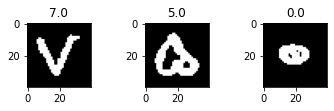

In [42]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

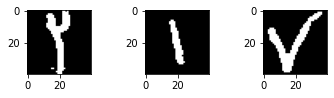

In [45]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))

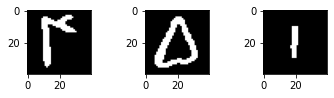

In [44]:
#val samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(val_images[i].squeeze(), cmap=plt.get_cmap('gray'))

### Convert images to tensors and Normalize it

In [46]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor.type(torch.LongTensor))

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor.type(torch.LongTensor))

#test
test_images_tensor = torch.tensor(test_images)/255.0

### Load images into the data generator

In [48]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=4, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=4, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=4, shuffle=False)

## Model

### Define the DCNN Model

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout2d(0.1)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout2d(0.2) 
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout2d(0.3) 
        )
        
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout2d(0.4) 
        )
        
        self.classification_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(1024, 10)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [53]:
DCNN_model = Net()
DCNN_model

Net(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

### Define the optimizer and loss functions

In [54]:
optimizer = optim.Adam(params=DCNN_model.parameters(), lr=0.003)
optimizer = optim.Adadelta(params=DCNN_model.parameters(), lr=0.003)
optimizer = optim.SGD(params=DCNN_model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    DCNN_model = DCNN_model.cuda()
    criterion = criterion.cuda()

### Training the Model

In [55]:
acc={'Val_acc':[] , 'Loss':[]}

def train_model(num_epoch):
    conv_model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
    exp_lr_scheduler.step()
    
def evaluate(data_loader):
    conv_model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = conv_model(data)
        
        loss += F.cross_entropy(output, target, reduction='sum').data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    
    acc['Val_acc'].append(100. * correct / len(data_loader.dataset))
    acc['Loss'].append(loss)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    

**after 8 epoch we get to 99 percent accuracy so we decrease the num_epoch from 25 to 10**

In [ ]:
#num_epochs = 10
start_time = time.time()
while(True):
    try:
        num_epochs = 10
        for n in range(num_epochs):
            train_model(n)
            evaluate(val_loader)
        break
    except:
        pass
print("--- %s seconds ---" % (time.time() - start_time))

### Make predictions on the test set

In [17]:
def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = conv_model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [18]:
test_set_preds = make_predictions(test_loader)

 0    9    2    3    6    1    9    8    4   

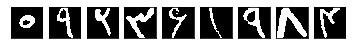

In [19]:
#test samples
for i in range(9):
    plt.subplot(1,9,i+1, xticks=[], yticks=[])
    print(f' {test_set_preds[i].item()}' , end="   ")
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()




In [20]:
from sklearn.metrics import accuracy_score


accuracy_score(test_labels , test_set_preds)

0.9945833333333334

In [21]:
wrongs=[]
for i,v in enumerate(test_set_preds):
    if v.item() != test_labels[i]:
        wrongs.append(i)

 3    3    4    5    5    3    9    7    6   

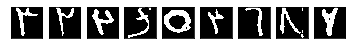

In [22]:
#Mistakes
for i,value in enumerate(wrongs[:9]):
    plt.subplot(1,9,i+1, xticks=[], yticks=[])
    print(f' {test_set_preds[value].item()}' , end="   ")
    plt.imshow(test_images[value].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()
